In [1]:
import numpy as np
from nilearn import image

# Load power template coords
powerfile = '/home/anton/Documents/Tulane/Hackathon/power264/power264MNI.nii.gz'

powerimg = image.load_img(powerfile)
datpower = image.get_data(powerimg)

print(datpower.shape)

(91, 109, 91)


In [2]:
# Sort power coordinates

pcoords = []
proinums = []

for roi in range(264):
    x,y,z = np.where(datpower == roi+1)
    pcoords.append(np.stack([x,y,z,np.ones(x.shape[0])]).T)
    proinums.append(roi*np.ones(x.shape[0]))
    
pcoords = np.concatenate(pcoords).T
proinums = np.concatenate(proinums)

print(pcoords.shape)
print(proinums.shape)

(4, 21384)
(21384,)


In [3]:
! ls ../UKBB_Cypress/func | wc -w

8057


In [4]:
import pandas as pd

csvname = '../UKB_MRI_data_11092022/UKB_Phenotypes/project3_Anton/DataSet_11162022.csv'
df = pd.read_csv(csvname)
df

,f.eid,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.21022.0.0,f.22001.0.0,f.25750.2.0,f.25750.3.0,f.25751.2.0,f.25751.3.0,f.25752.2.0,f.25752.3.0,f.25753.2.0,f.25753.3.0,f.25754.2.0,f.25754.3.0,f.25755.2.0,f.25755.3.0
0,1000010,50.0,NaN,NaN,NaN,50.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000028,52.0,NaN,NaN,NaN,52.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000034,56.0,NaN,NaN,NaN,56.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000045,43.0,NaN,NaN,NaN,43.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000052,61.0,NaN,NaN,NaN,61.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502481,6024820,68.0,NaN,NaN,NaN,68.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
502482,6024833,61.0,NaN,NaN,NaN,61.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
502483,6024847,64.0,NaN,NaN,NaN,64.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
502484,6024859,60.0,NaN,NaN,NaN,60.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
from scipy.interpolate import interpn
from pathlib import Path
import re

# Extract timeseries quickly

funcdir = '../UKBB_Cypress/func'
exp = re.compile('sub-(\d+)ses(\d)_task-([a-z]+)_.+\.nii\.gz')

fnames = []

skipped = 0
for f in Path(funcdir).iterdir():
    res = exp.match(f.name)
    if not res:
        continue
    sub = res.group(1)
    ses = res.group(2)
    task = res.group(3)
    
    if ses != '2' or task != 'rest':
#         print(f'Skipping {f.name}')
        skipped += 1
        continue
        
    fnames.append(dict(fname=f.name, sub=sub, ses=ses, task=task))
    
fnames.sort(key=lambda a: a['fname'])
print(skipped)
print(len(fnames))
print(fnames[0])
print(fnames[1])

4359
3696
{'fname': 'sub-1000076ses2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'sub': '1000076', 'ses': '2', 'task': 'rest'}
{'fname': 'sub-1000302ses2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'sub': '1000302', 'ses': '2', 'task': 'rest'}


In [7]:
import pickle

tsdict = dict()

low = 3600
inc = 200

for n in range(low,low+inc):
    if n >= len(fnames):
        break
    fname = fnames[n]['fname']
    sub = fnames[n]['sub']
    ses = fnames[n]['ses']
    task = fnames[n]['task']
    
    print(f'Doing {n} {fname}')
    
    imgname = f'{funcdir}/{fname}'
    img = image.load_img(imgname)
    datimg = image.get_data(img)
        
    coords = np.linalg.inv(img.affine)@powerimg.affine@pcoords
    points = [np.arange(s) for s in img.shape[:-1]]
        
    nt = datimg.shape[-1]
    ts = np.zeros((264,nt))
    res = np.zeros((nt,coords.shape[-1]))

    for tp in range(nt):
        res[tp] = interpn(points, datimg[:,:,:,tp], coords[:-1].T, bounds_error=False)

    for roi in range(264):
        ts[roi] = np.mean(res[:,proinums == roi], axis=1)
            
    val = (ses, task, ts)
    if sub in tsdict:
        tsdict[sub].append(val)
    else:
        tsdict[sub] = [val]
    
print('Complete')

with open(f'../UKBB_TS/ses2_rest_{low}-{low+inc}.pkl', 'wb') as f:
    pickle.dump(tsdict, f)
    
print('Wrote dict file')

Doing 3600 sub-1715326ses2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Doing 3601 sub-1715375ses2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Doing 3602 sub-1715409ses2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Doing 3603 sub-1715411ses2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Doing 3604 sub-1715483ses2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Doing 3605 sub-1715650ses2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Doing 3606 sub-1715698ses2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Doing 3607 sub-1715859ses2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Doing 3608 sub-1716489ses2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Doing 3609 sub-1716535ses2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Doing 3610 sub-1716583ses2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Doing 3611 sub-1716704ses2_task-

Doing 3694 sub-1732011ses2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Doing 3695 sub-1732083ses2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Complete
Wrote dict file


saddct = {sub['sub']: tsdict[sub['sub']] for sub in fnames[200:400]}

with open(f'../UKBB_TS/ses2_rest_{low}-{low+inc}.pkl', 'wb') as f:
    pickle.dump(saddct, f)
    
print('Done')

In [10]:
import pickle

inc = 200
top = 2000
tsdict = {}

for low in range(0,top,inc):
    with open(f'../UKBB_TS/ses2_rest_{low}-{low+inc}.pkl', 'rb') as f:
        dct = pickle.load(f)
        tsdict = tsdict | dct
        
print(len(tsdict.keys()))

2000


In [8]:
tss = []
ids = []
ages = []
qc_fail = ['1282043', '1524829', '1532804', '1728228']

for sub,valarr in tsdict.items():
#     if sub in qc_fail:
#         continue
    for val in valarr:
        if val[1] != 'rest' or val[0] != '2':
            continue
        tss.append(val[2])
        ids.append(sub)
        ages.append(df[df['f.eid'] == int(sub)]['f.21003.2.0'])
        ages[-1] = float(ages[-1])
        
from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 0.735
        
for i,ts in enumerate(tss):
    tss[i] = butter_bandpass_filter(ts, [0.01, 0.2], 1/tr)
    
len(tss)

400

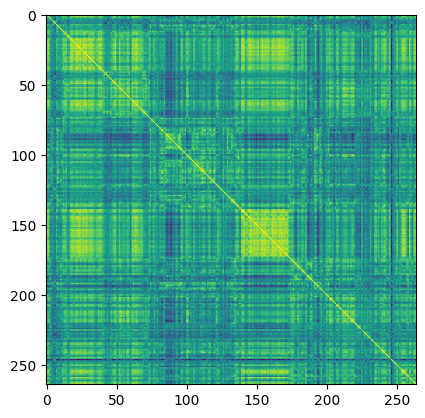

In [9]:
import matplotlib.pyplot as plt

# print(ids[3672])
p = np.corrcoef(tss[1542])
plt.imshow(p)
plt.show()

In [10]:
for i,ts in enumerate(tss):
    if np.sum(ts == 0) > 0:
        print(i)

1542
2575
2619
3673


In [7]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45, 
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85, 
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132, 
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186, 
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257, 
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8, 
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248, 
249, 252, 253]

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


In [9]:
import torch
import torch.nn as nn

a,b = np.triu_indices(264,1)
x = [np.corrcoef(ts)[a,b] for ts in tss]
x = np.stack(x)
x = np.concatenate([x, np.ones((x.shape[0], 1))], axis=1)
y = ages
y = np.array(y)

ntrain = 3300
idcs = torch.randperm(x.shape[0])

xx = torch.from_numpy(x).float().cuda()
xx = xx[idcs]
xtr = xx[:ntrain]
xt = xx[ntrain:]

yy = torch.from_numpy(y).float().cuda()
yy = yy [idcs]
ytr = yy[:ntrain]
yt = yy[ntrain:]

mseLoss = nn.MSELoss()

# w, _, _, _ = torch.linalg.lstsq(xtr.T@xtr+0*torch.eye(xtr.shape[-1]).float().cuda(),xtr.T@ytr)
w, _, _, _ = torch.linalg.lstsq(xtr,ytr)


yhat = torch.mean(ytr)
print(mseLoss(yhat*torch.ones(yt.shape).float().cuda(), yt)**0.5)

yhat = xt@w
print(mseLoss(yhat, yt)**0.5)

tensor(7.3981, device='cuda:0')
tensor(6.2308, device='cuda:0')


[[1.         0.65064848]
 [0.65064848 1.        ]]


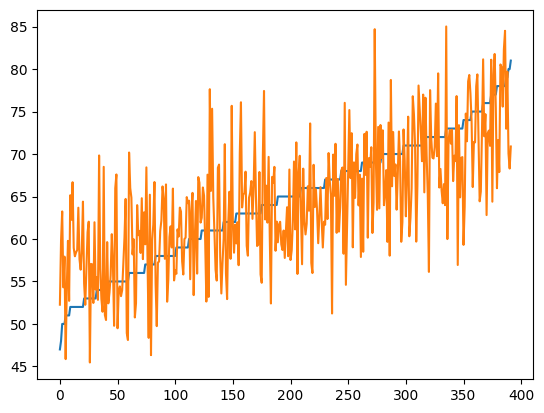

In [10]:
import matplotlib.pyplot as plt

ytnp = yt.detach().cpu().numpy()
idcs = np.argsort(ytnp)
yhatnp = yhat.detach().cpu().numpy()

print(np.corrcoef(ytnp, yhatnp))

plt.plot(ytnp[idcs])
plt.plot(yhatnp[idcs])
plt.show()